In [ ]:
# Import Required Library
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer


In [2]:
Buzzfeed = pd.read_csv("data/BuzzFeed_data.csv")

In [3]:
real_order=Buzzfeed[Buzzfeed['news_type']=='Real']['source'].value_counts().sort_values(ascending=False).index

In [4]:
real_order

Index(['http://politi.co', 'http://cnn.it', 'http://abcn.ws',
       'http://eaglerising.com', 'http://rightwingnews.com',
       'http://www.addictinginfo.org', 'http://addictinginfo.org',
       'http://www.ifyouonlynews.com', 'http://winningdemocrats.com',
       'http://occupydemocrats.com', 'http://www.opposingviews.com',
       'http://freedomdaily.com', 'http://conservativebyte.com',
       'https://www.washingtonpost.com'],
      dtype='object')

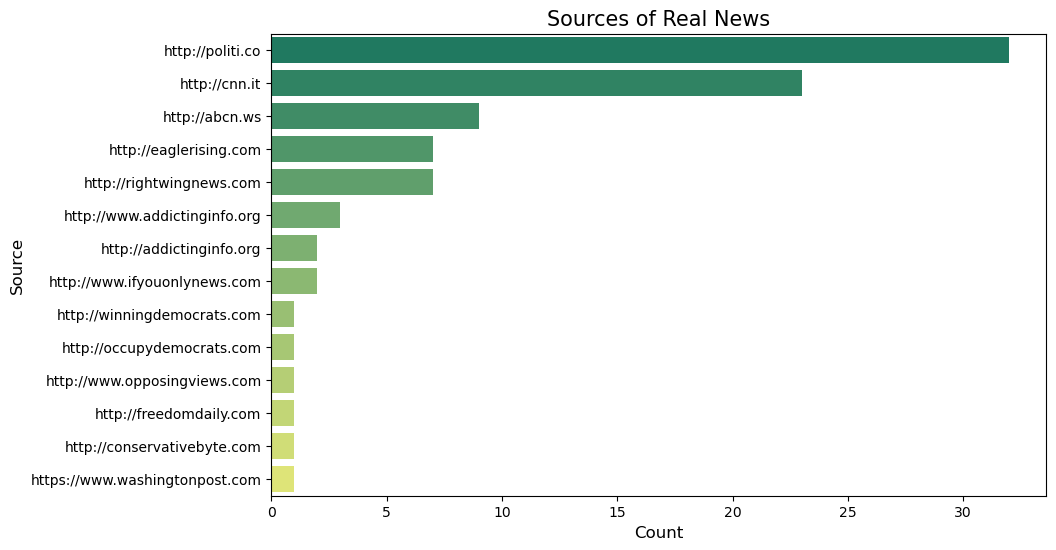

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=Buzzfeed[Buzzfeed['news_type']=='Real'],order=real_order,palette='summer')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Real News',fontsize=15)
plt.show()

In [6]:
fake_order=Buzzfeed[Buzzfeed['news_type']=='Fake']['source'].value_counts().sort_values(ascending=False).index

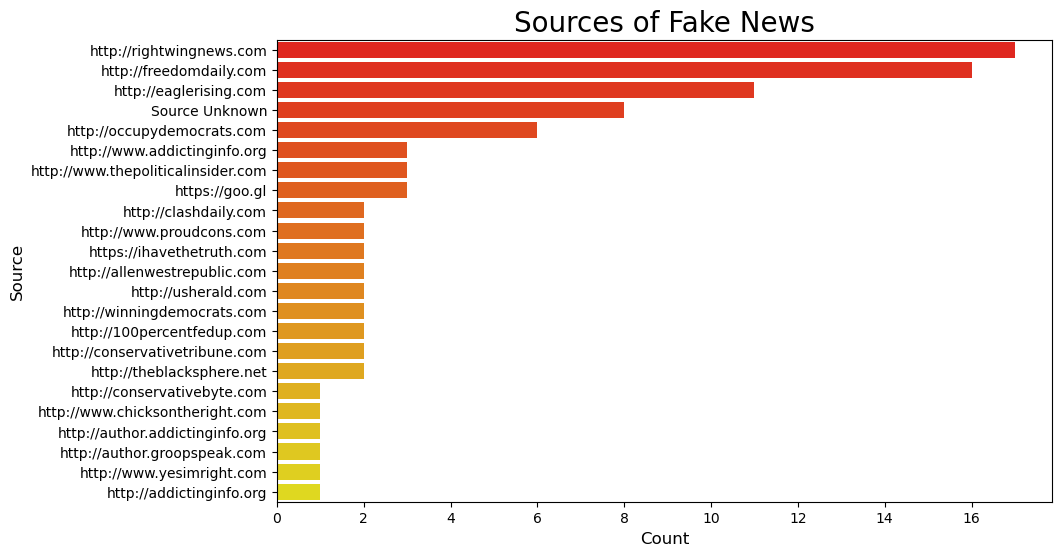

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(y='source',data=Buzzfeed[Buzzfeed['news_type']=='Fake'],order=fake_order,palette='autumn')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=20)
plt.show()

In [8]:
new=[]
for x in Buzzfeed[Buzzfeed['news_type']=='Fake']['source'].unique():
    if x in Buzzfeed[Buzzfeed['news_type']=='Real']['source'].unique():
        new.append(x)
print(new)

Buzzfeed_copy = Buzzfeed.copy()

Buzzfeed_copy['common']=Buzzfeed_copy['source'].apply(lambda x: x if x in new else 0)

Buzzfeed_plot = Buzzfeed_copy[Buzzfeed_copy['common']!=0]

['http://www.addictinginfo.org', 'http://eaglerising.com', 'http://conservativebyte.com', 'http://winningdemocrats.com', 'http://freedomdaily.com', 'http://occupydemocrats.com', 'http://rightwingnews.com', 'http://addictinginfo.org']


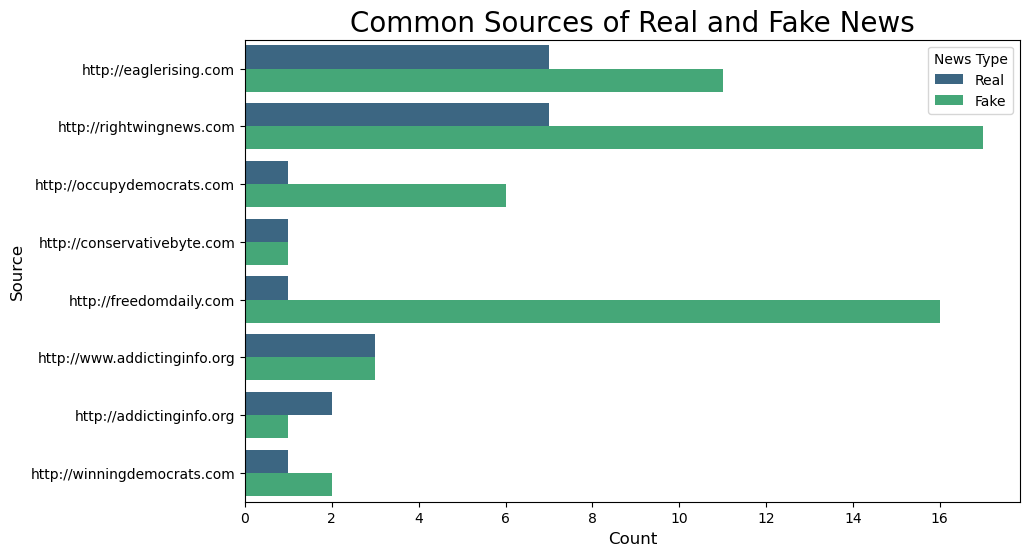

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(y='common',data=Buzzfeed_plot,hue='news_type',palette='viridis')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Common Sources of Real and Fake News',fontsize=20)
plt.show()

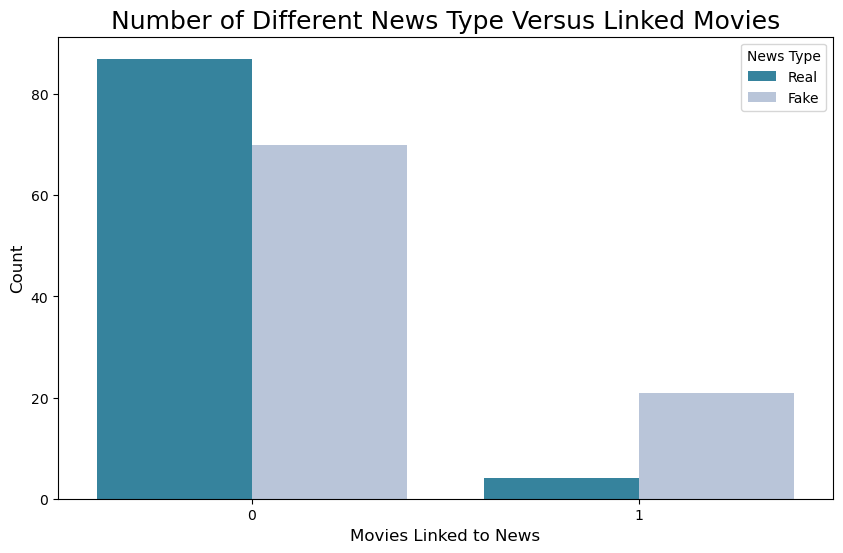

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_movies', data=Buzzfeed_copy, hue='news_type', palette='PuBuGn_r')
plt.xlabel('Movies Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Movies',fontsize=18)
plt.show()

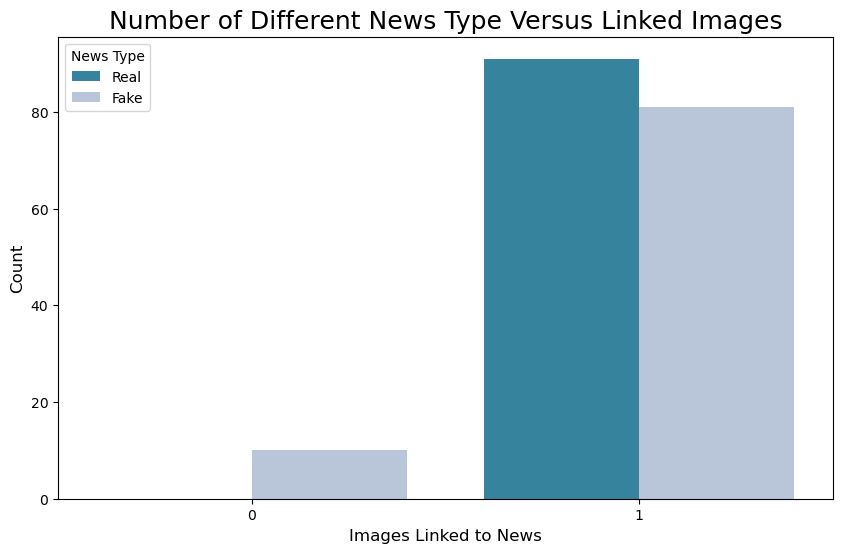

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_images', data=Buzzfeed_copy, hue='news_type', palette='PuBuGn_r')
plt.xlabel('Images Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='upper left', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Images',fontsize=18)
plt.show()

In [ ]:
# Text Preprocessing Functions
ps = PorterStemmer()
wst = WhitespaceTokenizer()

# Lowercase
def lower_func(x):
    return x.lower()

# Remove numbers
def remove_number_func(x): 
    return ''.join([a for a in x if not a.isdigit()])

# Remove punctuation
def remove_punc_func(x):
    return ''.join([a for a in x if a not in string.punctuation])

# Remove special characters
def remove_spec_char_func(x):
    return ''.join([a for a in x if a.isalnum() or a == ' '])

# Remove English stopwords (using sklearn)
def remove_stopwords(x):
    new = []
    for a in x.split():
        if a not in ENGLISH_STOP_WORDS:
            new.append(a)
    return " ".join(new)

# Stemming
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

# Remove extra whitespaces
def remove_whitespace_func(x):
    return(wst.tokenize(x))

# Function composition helper
def compose(f, g):
    return lambda x: f(g(x))

# Final preprocessing pipeline
final = compose(
    compose(
        compose(
            compose(
                compose(
                    compose(remove_whitespace_func, stem_func),
                    remove_stopwords
                ),
                remove_spec_char_func
            ),
            remove_punc_func
        ),
        remove_number_func
    ),
    lower_func
)

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /Users/wook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/wook/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

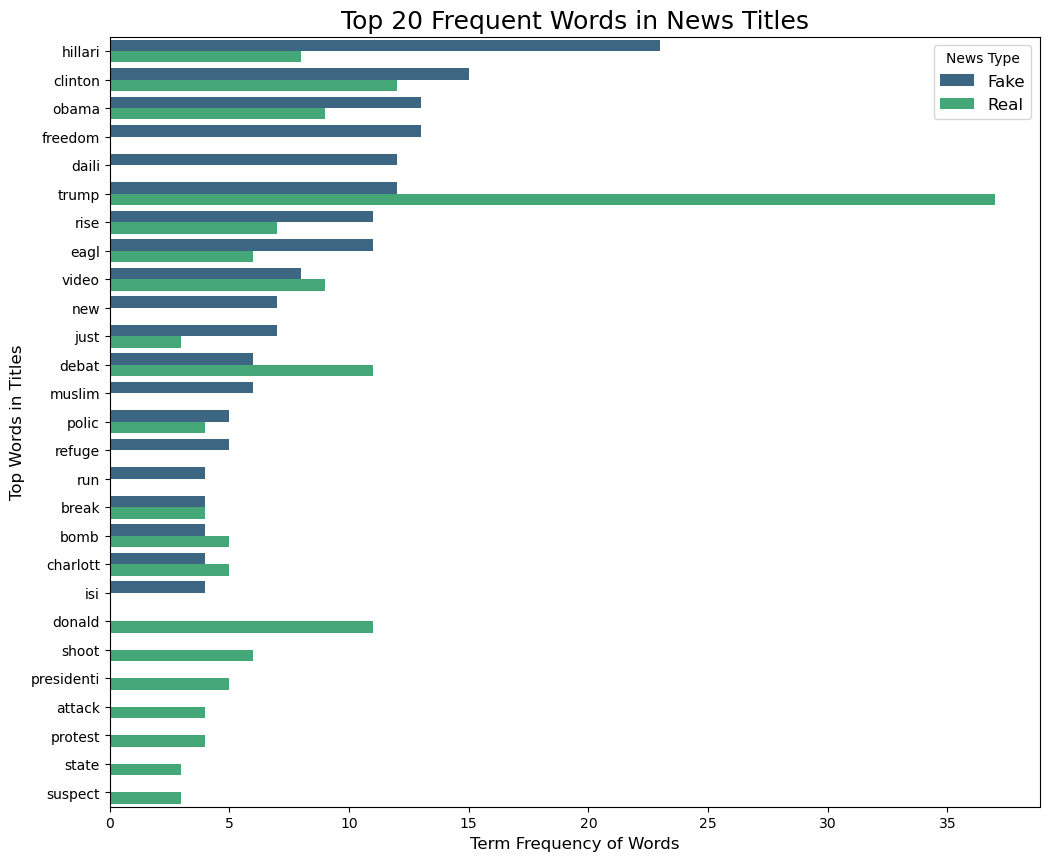

In [16]:
# Separate fake and real subsets
df_fake = Buzzfeed[Buzzfeed['news_type'] == 'Fake']
df_real = Buzzfeed[Buzzfeed['news_type'] == 'Real']

# Fake News Titles 
cv1 = CountVectorizer(analyzer=final)
bow1 = cv1.fit_transform(df_fake['title'])
matrix1 = pd.DataFrame(bow1.toarray(), columns=cv1.get_feature_names_out())

# Sum word frequencies
matrix1_sum = matrix1.sum().sort_values(ascending=False).head(20)
top1 = matrix1_sum.reset_index()
top1.columns = ['word', 'sum']
top1['type'] = 'Fake'

# Real News Titles
cv2 = CountVectorizer(analyzer=final)
bow2 = cv2.fit_transform(df_real['title'])
matrix2 = pd.DataFrame(bow2.toarray(), columns=cv2.get_feature_names_out())

matrix2_sum = matrix2.sum().sort_values(ascending=False).head(20)
top2 = matrix2_sum.reset_index()
top2.columns = ['word', 'sum']
top2['type'] = 'Real'

# Combine for Visualization
conc1 = pd.concat([top1, top2])

plt.figure(figsize=(12, 10))
sns.barplot(y='word', x='sum', hue='type', data=conc1, palette='viridis')
plt.xlabel('Term Frequency of Words', fontsize=12)
plt.ylabel('Top Words in Titles', fontsize=12)
plt.title('Top 20 Frequent Words in News Titles', fontsize=18)
plt.legend(title='News Type', fontsize=12)
plt.show()


In [21]:
conc1.sort_values(by='word')

,word,sum,type
15,attack,4,Real
11,bomb,5,Real
17,bomb,4,Fake
14,break,4,Real
16,break,4,Fake
12,charlott,5,Real
18,charlott,4,Fake
1,clinton,12,Real
1,clinton,15,Fake
4,daili,12,Fake


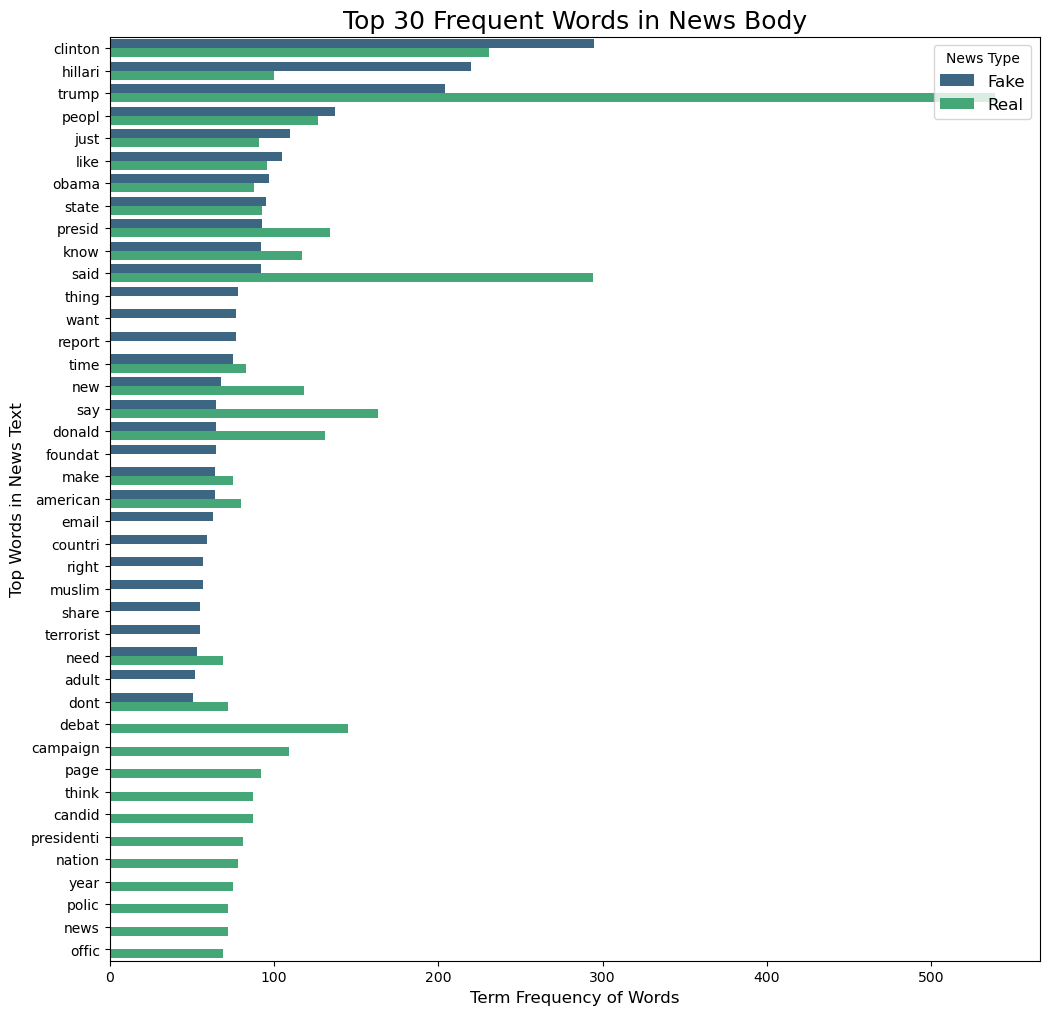

In [17]:
# Fake News Body 
cv3 = CountVectorizer(analyzer=final)
bow3 = cv3.fit_transform(df_fake['text'])
matrix3 = pd.DataFrame(bow3.toarray(), columns=cv3.get_feature_names_out())

matrix3_sum = matrix3.sum().sort_values(ascending=False).head(30)
top3 = matrix3_sum.reset_index()
top3.columns = ['word', 'sum']
top3['type'] = 'Fake'

# Real News Body 
cv4 = CountVectorizer(analyzer=final)
bow4 = cv4.fit_transform(df_real['text'])
matrix4 = pd.DataFrame(bow4.toarray(), columns=cv4.get_feature_names_out())

matrix4_sum = matrix4.sum().sort_values(ascending=False).head(30)
top4 = matrix4_sum.reset_index()
top4.columns = ['word', 'sum']
top4['type'] = 'Real'

# Combine and Visualize 
conc2 = pd.concat([top3, top4])

plt.figure(figsize=(12, 12))
sns.barplot(y='word', x='sum', hue='type', data=conc2, palette='viridis')
plt.xlabel('Term Frequency of Words', fontsize=12)
plt.ylabel('Top Words in News Text', fontsize=12)
plt.title('Top 30 Frequent Words in News Body', fontsize=18)
plt.legend(title='News Type', fontsize=12)
plt.show()


In [19]:
# Define output directory
output_directory = 'data/'

# Save each top DataFrame to CSV
top1.to_csv(output_directory + 'top1_fake_title.csv', index=False)
top2.to_csv(output_directory + 'top2_fake_title.csv', index=False)
top3.to_csv(output_directory + 'top3_fake_title.csv', index=False)
top4.to_csv(output_directory + 'top4_fake_title.csv', index=False)